## C01.01.F4.01. Feature Selection. Direct dataset. Selected Features

# Script for selecting the best features to train the model.

It is necessary to remove those features that will not be relevant to the 
training of the model and thus improve performance. First the correlation 
matrix of the independent variables is obtained and those with a high 
percentage of correlation are eliminated. Then, using the RFECV 
method, the most significant ones are chosen.

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.model_selection import  GroupKFold 
import lightgbm as ltb
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time 
import os
import sys

t1 = time.time()

In [2]:
# Define INPUT and OUTPUT files
INPUT = '../../F3.Data Preparation/02_Data/Direct_sampled_train.csv'

OUTPUT_FEATS = '../02_Data/Direct_features.npy'
OUTPUT = '../02_Data/Direct_prepared_train.csv'

In [3]:
# Read data resetting the indexes
data = pd.read_csv(INPUT, sep='|').reset_index(drop=True)

In [5]:
# Store in array all unnecessary    
to_delete = ['CUSTOMER_ID', 'BRANDFAMILY_ID', 'DATE_init', 'DATE_end','SO_ITG_WSE', 'SO_MRKT_WSE','QUOTA_SELLOUT']

   
# Create data copy by removing unnecessary columns in X and the sellout field in y
X = data.drop(to_delete, axis=1)
y = data['QUOTA_SELLOUT']

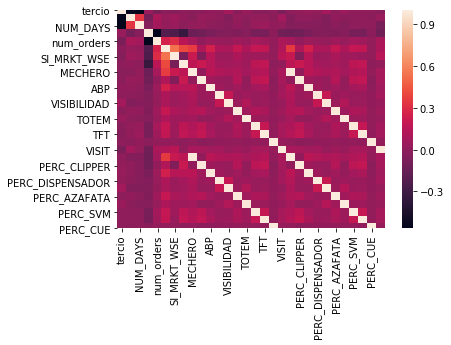

In [6]:
# Get correlations between independent variables and show heatmap
correlations = X.corr()
sns.heatmap(correlations)

In [7]:
# Eliminate those independent variables that have a greater than 95% correlation between them 
threshold = 0.95
ignored_fields = []
for c in correlations.iterrows():
    sort = c[1].sort_values(ascending=False)
    if sort[1] > threshold or sort[1] < -threshold:
        correlations = correlations.drop(c[0], axis = 0)
        correlations = correlations.drop(c[0], axis = 1)
        ignored_fields.append(c[0])

X = X.drop(ignored_fields, axis=1)

In [8]:
# Apply a data scaling with StandardScaler on the data
columns = list(X.columns.values)
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

In [9]:
# Create peer groups of customers for cross-validation
groups = data.CUSTOMER_ID
group_KFold = GroupKFold(n_splits=5)

In [10]:
# Define model and fit RFECV (recursive feature elimination) with cross-validation
# to get the feature ranking
estimator = ltb.LGBMRegressor()
rfe = RFECV(estimator=estimator, min_features_to_select=30, step=5, cv=group_KFold.split(X, y, groups), n_jobs=4, verbose=1)
rfe.fit(X, y)

RFECV(cv=<generator object _BaseKFold.split at 0x00000253A00E7B48>,
      estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                              colsample_bytree=1.0, importance_type='split',
                              learning_rate=0.1, max_depth=-1,
                              min_child_samples=20, min_child_weight=0.001,
                              min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                              num_leaves=31, objective=None, random_state=None,
                              reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                              subsample=1.0, subsample_for_bin=200000,
                              subsample_freq=0),
      min_features_to_select=30, n_jobs=4, scoring=None, step=5, verbose=1)

In [12]:
# Get best features and save to file
features = rfe.get_support(indices = True) 
best_features = list(np.array(columns)[features])

X = data[best_features+['CUSTOMER_ID','BRANDFAMILY_ID','DATE_init','DATE_end','QUOTA_SELLOUT']]

np.save(OUTPUT_FEATS, list(best_features))

In [13]:
# The data is written to a file
X.to_csv(OUTPUT, sep='|', index=False, mode='w')

In [14]:
t2 = time.time()
print ("Time to execute script:",str(round((t2-t1)/3600,2)), "h")

Time to execute script: 0.15 h
